In [1]:
from math import floor

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


from src.LinearSimulator import Simulator, SimpleSSM
from src.control.SimpleMPC import MPC
from src.utils import set_seed

## Setup simulator and model


In [2]:
device = 'cpu'
set_seed(seed=0, use_cuda=False)

In [3]:
state_dim = 2
action_dim = 3

model = SimpleSSM(state_dim, action_dim).to(device)
simul = Simulator(state_dim, action_dim, noise=0.01).to(device)

A=np.array([[0.9, 0.1],
            [0.1, 0.9]])

B=np.array([[1, -1],
            [-1, 2],
            [-2, 1]])

model.A.weight.data = torch.tensor(A, device=device).float()
simul.A.weight.data = torch.tensor(A, device=device).float()
model.B.weight.data = torch.tensor(B, device=device).float()
simul.B.weight.data = torch.tensor(B, device=device).float()

In [4]:
action_min = -1.0
action_max = +1.0
H = 5
T = 100

## Set target trajectory

In [5]:
x_ref = torch.ones((T, state_dim), device=device) * 2.0
recession_period = floor(T * 0.1)
x_ref[:recession_period, :] = 0
x_ref[-recession_period:, :] = 0

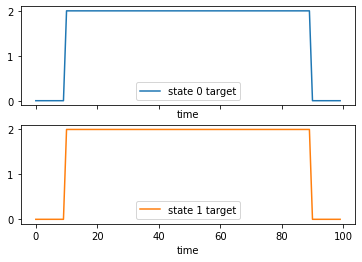

In [6]:
fig, axes = plt.subplots(2,1, sharex=True)
for i in range(2):
    axes[i].plot(x_ref[:,i].to('cpu'), 
                 color='C{}'.format(i),
                 label='state {} target'.format(i))
    axes[i].set_xlabel('time')
    axes[i].legend()

In [7]:
solver = MPC(model=model,
             state_dim=state_dim,
             action_dim=action_dim,
             H=H,
             action_min=action_min,
             action_max=action_max).to(device)

In [8]:
x = torch.zeros((1,state_dim), device=device)
state_trajectory = []
action_trajectory = []
opt_results = []

for itr in range(T-H):    
    # Solve MPC problem
    
    state_ref = x_ref[itr:itr+H,:]
    state_ref = state_ref.unsqueeze(dim=0) # add batch dim
    us, info = solver.solve(x0=x, target=state_ref, max_iter=2000)    
    action = us[:,0,:]
    
    print("Step {:2d} | loss {:.7f} | solve : {}".format(itr, info['loss'], info['solve']))
    
    # perform simulation with the optmized action
    with torch.no_grad():        
        x = simul(x, action.view(1,-1))
    
    action_trajectory.append(action)
    state_trajectory.append(x)
    opt_results.append(action)

Step  0 | loss 0.0000097 | solve : True
Step  1 | loss 0.0000094 | solve : True
Step  2 | loss 0.0000097 | solve : True
Step  3 | loss 0.0000096 | solve : True
Step  4 | loss 0.0000072 | solve : True
Step  5 | loss 0.0000099 | solve : True
Step  6 | loss 0.1000076 | solve : False
Step  7 | loss 0.1000084 | solve : False
Step  8 | loss 0.4141988 | solve : False
Step  9 | loss 0.1000024 | solve : False
Step 10 | loss 0.0505520 | solve : False
Step 11 | loss 0.0000099 | solve : True
Step 12 | loss 0.0000098 | solve : True
Step 13 | loss 0.0000096 | solve : True
Step 14 | loss 0.0000076 | solve : True
Step 15 | loss 0.0000099 | solve : True
Step 16 | loss 0.0000098 | solve : True
Step 17 | loss 0.0000099 | solve : True
Step 18 | loss 0.0000097 | solve : True
Step 19 | loss 0.0000098 | solve : True
Step 20 | loss 0.0000096 | solve : True
Step 21 | loss 0.0000096 | solve : True
Step 22 | loss 0.0000080 | solve : True
Step 23 | loss 0.0000099 | solve : True
Step 24 | loss 0.0000099 | solve : 

In [9]:
controlled = np.concatenate(state_trajectory, axis=0)

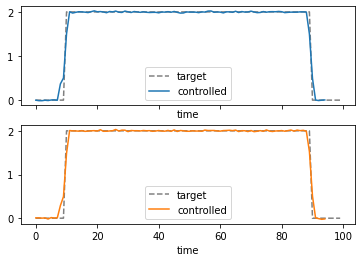

In [10]:
fig, axes = plt.subplots(2,1, sharex=True)
for i in range(2):
    axes[i].plot(x_ref[:,i].to('cpu'), 
                 color='gray',
                 ls='--',
                 label='target'.format(i))
    axes[i].plot(controlled[:,i], 
                 color='C{}'.format(i),
                 label='controlled'.format(i))
    axes[i].set_xlabel('time')
    axes[i].legend()